<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Light_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as unp 
import scipy
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chisquare
from scipy import ndimage, misc

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

# Camera Images

In [1]:
#@title Load Images

!pip3 install pickle5
import pickle5 as pickle
with open('/content/drive/MyDrive/LIME/Z_scan/images.pkl', "rb") as fh:
  images = pickle.load(fh)
images.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Run,z[cm],Image,CMOS_integral,CMOS_mean,CMOS_rms,Pedestal,NRedPix,RedPix_ix,RedPix_iy,RedPix_iz,Nclusters
0,5862.0,0.0,0.0,4076760.50,0.767981,2.919921,5861.0,4144.0,"[648, 648, 648, 648, 649, 649, 649, 649, 650, ...","[488, 489, 490, 491, 488, 489, 490, 491, 488, ...","[12.0, 2.9, 0.2, 3.5, -2.6, 3.1, 13.4, 12.9, -...",47.0
1,5862.0,0.0,1.0,3646410.25,0.686911,2.593899,5861.0,5696.0,"[1736, 1736, 1736, 1736, 1737, 1737, 1737, 173...","[1024, 1025, 1026, 1027, 1024, 1025, 1026, 102...","[0.6, -1.4, 3.1, 5.0, 0.5, -8.7, -0.7, -2.6, -...",56.0
2,5862.0,0.0,2.0,3918009.25,0.738075,2.683061,5861.0,5040.0,"[840, 840, 840, 840, 841, 841, 841, 841, 842, ...","[1868, 1869, 1870, 1871, 1868, 1869, 1870, 187...","[1.4, -2.4, 4.4, 0.3, -6.5, 0.8, 0.7, 1.1, 11....",63.0
3,5862.0,0.0,3.0,3346069.25,0.630333,2.402215,5861.0,3072.0,"[1796, 1796, 1796, 1796, 1797, 1797, 1797, 179...","[2236, 2237, 2238, 2239, 2236, 2237, 2238, 223...","[-8.6, 7.5, 12.9, -1.2, 12.1, 0.3, 8.0, 8.3, -...",24.0
4,5862.0,0.0,4.0,3526009.00,0.664230,2.482810,5861.0,3440.0,"[1732, 1732, 1732, 1732, 1733, 1733, 1733, 173...","[948, 949, 950, 951, 948, 949, 950, 951, 948, ...","[0.5, 2.6, -2.4, 2.9, 6.9, 13.1, 2.7, 1.5, 6.0...",46.0


In [ ]:
#@title Function to make map of consistent plots
def fullres_map(data, runs, filename):
  X = np.zeros(0)
  Y = np.zeros(0)
  Z = np.zeros(0)
  for run in runs:
    for image in range(400):
      try:
        X = np.concatenate((X,data['RedPix_ix'].loc[(data['Run']==run) & (data['Image']==image)].item()), axis=None)
        Y = np.concatenate((Y,data['RedPix_iy'].loc[(data['Run']==run) & (data['Image']==image)].item()), axis=None)
        Z = np.concatenate((Z,data['RedPix_iz'].loc[(data['Run']==run) & (data['Image']==image)].item()), axis=None)
      except:
        print('Error representing image no.', image)
  fig = plt.figure()
  hb = plt.hexbin(X, Y, C=Z, reduce_C_function=np.sum, cmap='hot', gridsize = 2304)
  plt.close(fig)

  picture = np.zeros((2304,2304))

  i = 0
  for pixel in hb.get_offsets():
    picture[int(pixel[1]), int(pixel[0])] = int(hb.get_array()[i])
    i = i+1
  filtered = ndimage.median_filter(picture, size=20) # median filter to remove hotspots

  fig, (ax) = plt.subplots(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k') 
  plt.imshow(filtered, cmap='inferno')
  ax.set_ylabel('Y [pixels]', y=0.5, ha='center', fontsize=24)
  ax.tick_params(axis='both', which='major', labelsize=20)
  ax.set_xlabel('X [pixels]', x=0.5, ha='center', fontsize=24)
  plt.tight_layout()
  plt.show()

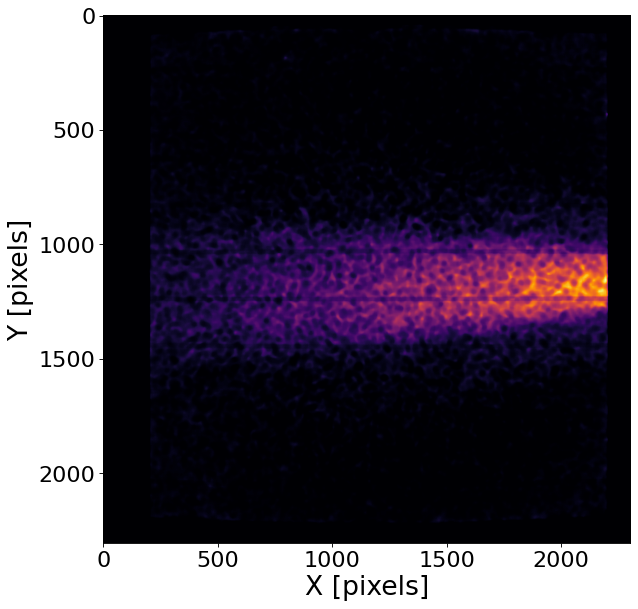

In [ ]:
#@title Map of Consistent Runs for Z = 25 cm
fullres_map(images, [5887, 5888, 5889, 5890, 5891], 'Z = 25 cm')

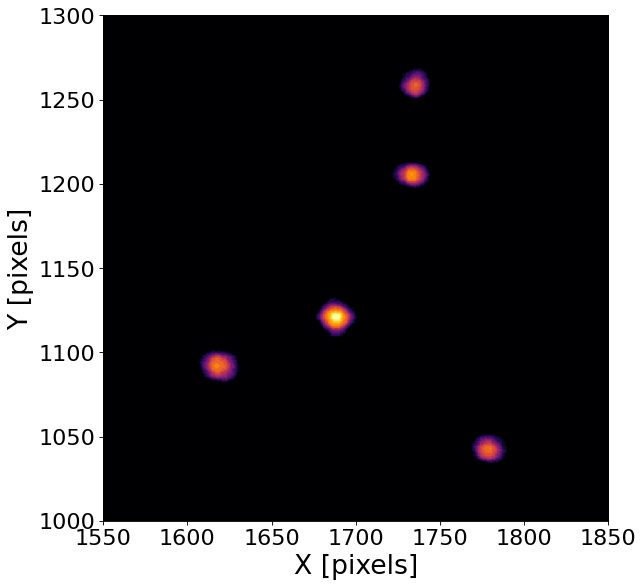

In [80]:
#@title Image of $^{55}$Fe clusters for Z = 25 cm (Run 5887, Image 100)

fig = plt.figure()
X = images['RedPix_ix'].loc[(images['Run']==5887) & (images['Image']==100)].item()
Y = images['RedPix_iy'].loc[(images['Run']==5887) & (images['Image']==100)].item()
Z = images['RedPix_iz'].loc[(images['Run']==5887) & (images['Image']==100)].item()
hb = plt.hexbin(X, Y, C=Z, reduce_C_function=np.sum, cmap='hot', gridsize = 2000)
plt.close(fig)
picture = np.zeros((2304,2304))

i = 0
for pixel in hb.get_offsets():
  picture[int(pixel[1]), int(pixel[0])] = int(hb.get_array()[i])
  i = i+1
filtered = ndimage.median_filter(picture, size=20) # median filter to remove hotspots

fig, (ax) = plt.subplots(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k') 
plt.imshow(filtered, cmap='inferno')
plt.xlim(1550,1850)
plt.ylim(1000,1300)
ax.set_ylabel('Y [pixels]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('X [pixels]', x=0.5, ha='center', fontsize=24)
plt.tight_layout()
plt.show()

Average circle radius =  1.06+/-0.31 mm
Average circle diameter =  2.1+/-0.6 mm


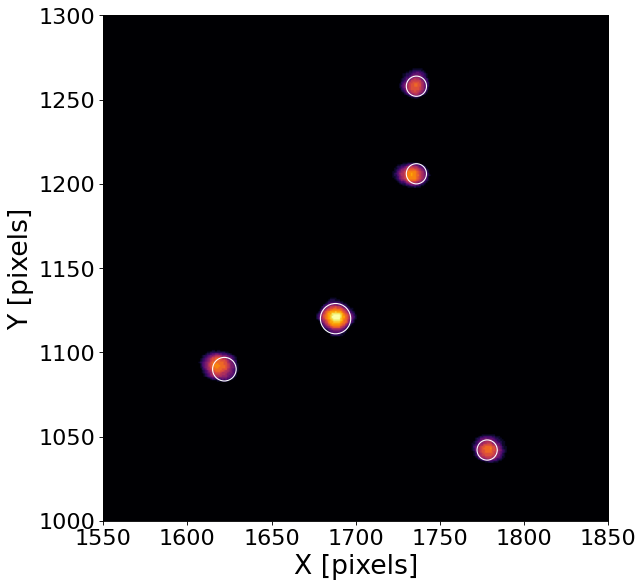

In [89]:
#@title Determination of the average radius of the 55Fe spots (Run 5887, Image 100)
import cv2
fig, (ax) = plt.subplots(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k') 
radius = []
img = np.array(filtered, dtype=np.uint8)
#gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
output=img.copy()
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, minDist=10, param1=9, param2=9, minRadius=1, maxRadius=20)
plt.imshow(output, cmap='inferno')

if circles is not None:
  circles = np.round(circles[0, :]).astype("int")
  for (x, y, r) in circles:
    ax.add_patch(plt.Circle((x, y), r, edgecolor='w', facecolor='none'))
    cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    #print(x,y,r)
    radius.append(r)
        
plt.xlim(1550,1850)
plt.ylim(1000,1300)
ax.set_ylabel('Y [pixels]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('X [pixels]', x=0.5, ha='center', fontsize=24)
plt.tight_layout()
plt.plot()
print('Average circle radius = ', 0.155*ufloat(np.mean(radius), 2*np.std(radius)), 'mm')
print('Average circle diameter = ', 2*0.155*ufloat(np.mean(radius), 2*np.std(radius)), 'mm')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

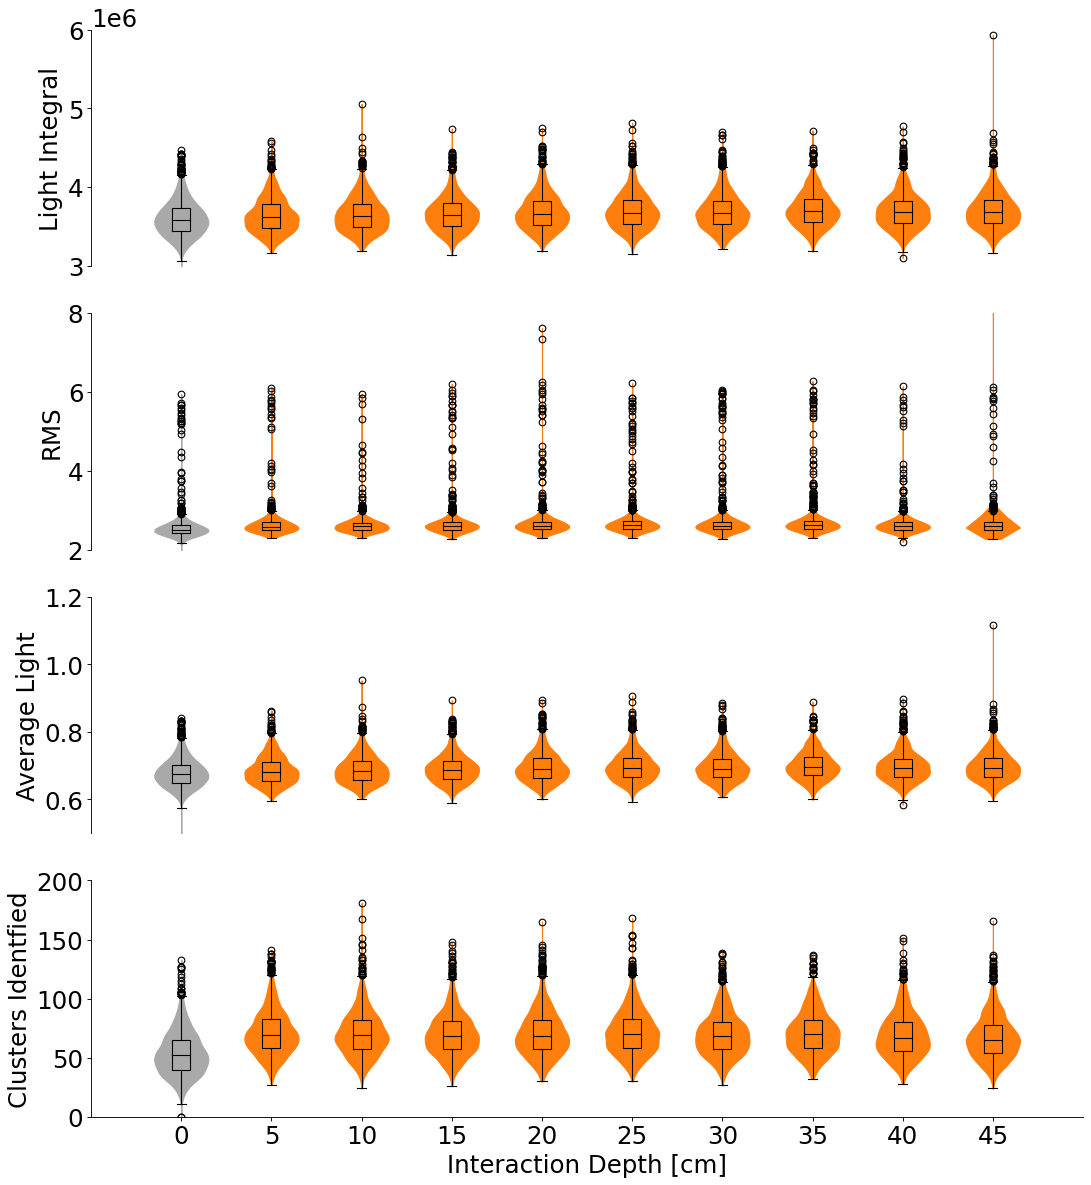

In [47]:
#@title Global Variables
fig, (ax) = plt.subplots(4,1, figsize=(16, 18), dpi= 80, facecolor='w', edgecolor='k') 

i = 0

for parameter, ymin, ymax, title in zip(['CMOS_integral', 'CMOS_rms', 'CMOS_mean', 'Nclusters'], [3e6, 2, 0.5, 0], [6e6, 8, 1.2, 200], ['Light Integral', 'RMS', 'Average Light', 'Clusters Identfied']):

    # Background
    box = ax[i].boxplot(images[parameter].loc[images['z[cm]']==0], positions=[0], widths=1)
    plt.setp(box['whiskers'], color='k')
    plt.setp(box['fliers'], markeredgecolor='k')
    plt.setp(box['boxes'], color='k')
    plt.setp(box['caps'], color='k')
    plt.setp(box['medians'], color='k')

    violin = ax[i].violinplot(images[parameter].loc[images['z[cm]']==0], positions=[0], widths=3, showextrema=False)
    plt.setp(violin['bodies'], color='darkgray', alpha=1)

    # Images
    data = []

    for d in [5,10,15,20,25,30,35,40,45]:
        data.append(np.array(images[parameter].loc[images['z[cm]']==d]))

    box = ax[i].boxplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=1)
    plt.setp(box['whiskers'], color='k')
    plt.setp(box['fliers'], markeredgecolor='k')
    plt.setp(box['boxes'], color='k')
    plt.setp(box['caps'], color='k')
    plt.setp(box['medians'], color='k')

    violin = ax[i].violinplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=3, showextrema=False)
    plt.setp(violin['bodies'], color='tab:orange', alpha=1)

    ax[i].set_xlim(-5,50)
    ax[i].set_ylim(ymin, ymax)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].set_ylabel(title, y=0.5, ha='center', fontsize=22)
    ax[i].tick_params(axis='both', which='both', labelsize=22)
    ax[i].yaxis.get_offset_text().set_fontsize(22)
    if i!=3:
        ax[i].get_xaxis().set_visible(False)
        ax[i].spines["bottom"].set_visible(False)
    else:
        ax[i].set_xlabel('Interaction Depth [cm]', x=0.5, ha='center', fontsize=22)
    i = i+1

plt.show()

# Cluster Analysis

In [50]:
#@title Load cluster data

def gauss(x,A,x0,s):
    return A*np.exp(-(x-x0)**2/(2*s**2))

roi = pd.read_csv('/content/drive/MyDrive/LIME/Z_scan/roi.csv')
original = pd.read_csv('/content/drive/MyDrive/LIME/Z_scan/sc.csv')
roi['R']=np.sqrt((roi['xMean']-(2304/2))**2+(roi['yMean']-(2304/2))**2) # Distance from the center
roi.describe()

,z[cm],Hits,Integral,Length,Width,Slim,PathLen,CorrIntegral,xMax,xMin,...,LAmp,LMean,LSigma,Long_RMS,MAmp,MFWHM,MMean,MProm,Pixel,R
count,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.0,251440.000000,251440.000000,251440.000000,...,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000
mean,24.402303,406.991577,7387.418094,37.527159,31.462311,0.840268,-1.0,28709.457663,1423.350016,1389.534839,...,1093.674008,18.637897,6.170157,5.878410,1228.683430,5.574327,18.819076,1162.892885,7129.694050,575.906634
std,12.406499,110.683815,1835.943276,4.963289,4.798911,0.086205,0.0,7095.156578,556.467129,556.087405,...,214.779881,3.070184,1.083172,0.917130,240.512170,1.734003,3.881874,247.476867,4599.808717,275.250941
min,0.000000,100.000000,1456.721000,19.000000,14.569679,0.600019,-1.0,6002.030000,223.000000,204.000000,...,300.603300,8.045532,2.623837,2.300020,403.312230,2.000282,5.500000,400.121250,0.000000,1.943643
25%,15.000000,326.000000,6137.715575,34.358808,27.888294,0.782432,-1.0,24335.557750,987.000000,952.000000,...,955.646050,16.560118,5.422654,5.259190,1072.313125,4.029987,16.000000,1001.251877,3424.000000,343.863777
50%,25.000000,412.000000,7534.881300,37.915604,31.737520,0.848713,-1.0,29134.941500,1519.000000,1484.000000,...,1092.255700,18.576963,6.225338,5.943493,1213.978650,5.707380,19.000000,1150.739000,6704.000000,575.465301
75%,35.000000,490.000000,8730.483500,41.027379,35.124967,0.901700,-1.0,33431.991500,1907.000000,1872.000000,...,1225.771125,20.597599,6.939002,6.538057,1374.043250,6.965137,21.500000,1313.813050,10224.000000,813.210276
max,45.000000,798.000000,15159.720000,49.996555,49.548534,1.000000,-1.0,59992.797000,2207.000000,2192.000000,...,1994.883800,29.997269,9.988285,8.998210,2093.593300,10.982183,35.000000,1999.858400,29472.000000,1175.128896


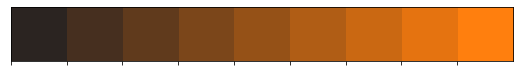

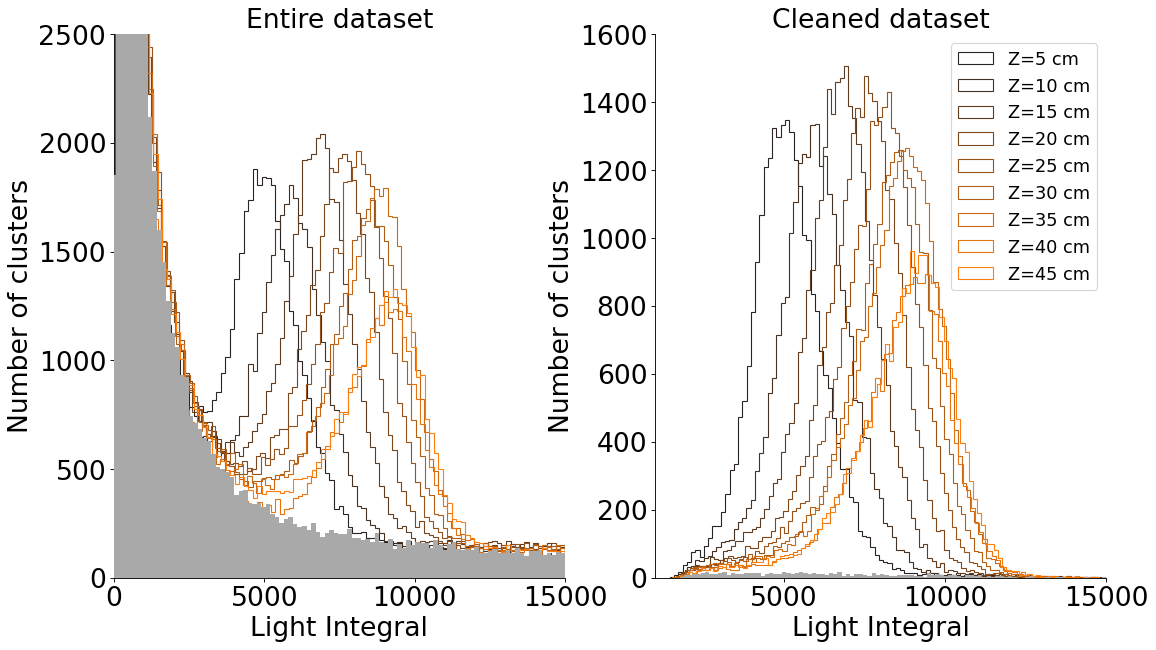

In [49]:
#@title Influence of Data Cleaning 
nbin=100
color = get_color(9, 'tab:orange')
i=0

fig, (ax) = plt.subplots(1,2, figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
ax[0].set_title('Entire dataset', fontsize=24)
ax[1].set_title('Cleaned dataset', fontsize=24)

ax[0].hist(original['Integral'].loc[(original['z[cm]']==0) & (original['Integral']<15000)], bins=nbin, color='darkgray', zorder=5)
ax[1].hist(roi['Integral'].loc[roi['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)

for dist in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  ax[0].hist(original['Integral'].loc[(original['z[cm]']==dist) & (original['Integral']<15000)], bins=nbin, histtype='step', lw=1, color=color[i])
  ax[1].hist(roi['Integral'].loc[(roi['z[cm]']==dist) & (roi['Integral']<15000)], bins=nbin, histtype='step', lw=1, color=color[i], label='Z='+str(dist)+' cm')
  i=i+1
ax[1].legend(fontsize=16, loc=0)
ax[0].set_xlim(0,15000)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=24)
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[0].set_xlabel('Light Integral', x=0.5, ha='center', fontsize=24)
ax[0].set_ylim(0,2500)

ax[1].set_xlim(1000,15000)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[1].set_xlabel('Light Integral', x=0.5, ha='center', fontsize=24)
ax[1].set_ylim(0,1600)


plt.show()

A= 320+/-7
x0= 8767+/-23
sigma= 881+/-23
eres= 10.05+/-0.27


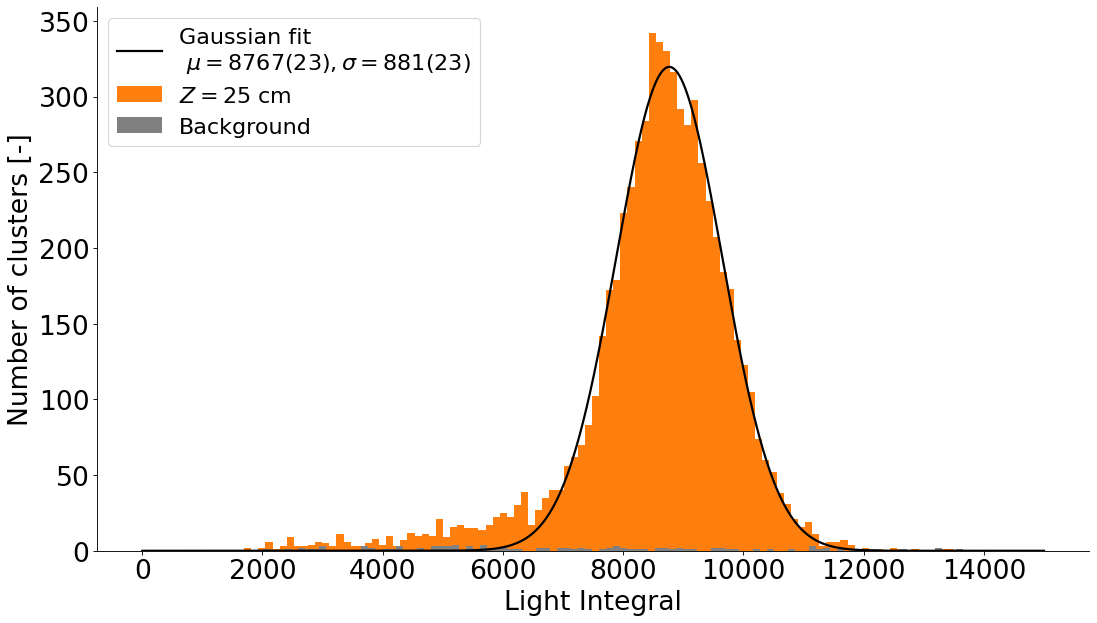

In [51]:
#@title Spectrum example for Z=25 cm, for clusters within 300 px of the centre
fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 

n, bins, patches = plt.hist(roi['Integral'].loc[(roi['z[cm]']==25) & (roi['R']<=300)], bins=100, color='tab:orange', label='$Z = 25$ cm')
plt.hist(roi['Integral'].loc[(roi['z[cm]']==0) & (roi['R']<=300)], bins=100, color='gray', label='Background')
bin_middles = (bins[1:]+bins[:-1])/2
x = np.linspace(0,15000, 15000)
bpopt, bpcov = curve_fit(gauss, bin_middles, n, p0=[np.max(n), np.mean(9000), 1000])
bpcov = np.sqrt(np.diag(bpcov))
ycalc = gauss(x, *bpopt)
plt.plot(x, ycalc, lw=2, color='k', label='Gaussian fit\n $\mu=8767(23), \sigma=881(23)$')
plt.legend(fontsize=20, loc=2)
print('A=', ufloat(bpopt[0], 2*bpcov[0]))
print('x0=', ufloat(bpopt[1], 2*bpcov[1]))
print('sigma=', ufloat(bpopt[2], 2*bpcov[2]))
print('eres=', ufloat(bpopt[2], 2*bpcov[2])/ufloat(bpopt[1], 2*bpcov[1])*100)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel('Light Integral', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_ylabel('Number of clusters [-]', x=0.5, ha='center', fontsize=24)

plt.show()

Z= 5 cm:
A= 264+/-8
x0= 5444+/-34
sigma= 916+/-34
eres= 39.6+/-1.5


'----------------------------------------------------------------------------------------------------'

Z= 10 cm:
A= 243+/-8
x0= 6455+/-35
sigma= 964+/-35
eres= 35.2+/-1.3


'----------------------------------------------------------------------------------------------------'

Z= 15 cm:
A= 307+/-8
x0= 7381+/-27
sigma= 931+/-27
eres= 29.7+/-0.9


'----------------------------------------------------------------------------------------------------'

Z= 20 cm:
A= 309+/-6
x0= 8190+/-21
sigma= 902+/-21
eres= 25.9+/-0.6


'----------------------------------------------------------------------------------------------------'

Z= 25 cm:
A= 320+/-7
x0= 8767+/-23
sigma= 881+/-23
eres= 23.7+/-0.6


'----------------------------------------------------------------------------------------------------'

Z= 30 cm:
A= 281+/-8
x0= 9205+/-30
sigma= 905+/-30
eres= 23.2+/-0.8


'----------------------------------------------------------------------------------------------------'

Z= 35 cm:
A= 307+/-7
x0= 9493+/-25
sigma= 922+/-25
eres= 22.9+/-0.6


'----------------------------------------------------------------------------------------------------'

Z= 40 cm:
A= 210+/-6
x0= 9759+/-29
sigma= 908+/-29
eres= 21.9+/-0.7


'----------------------------------------------------------------------------------------------------'

Z= 45 cm:
A= 242+/-8
x0= 9838+/-34
sigma= 907+/-34
eres= 21.7+/-0.8


'----------------------------------------------------------------------------------------------------'

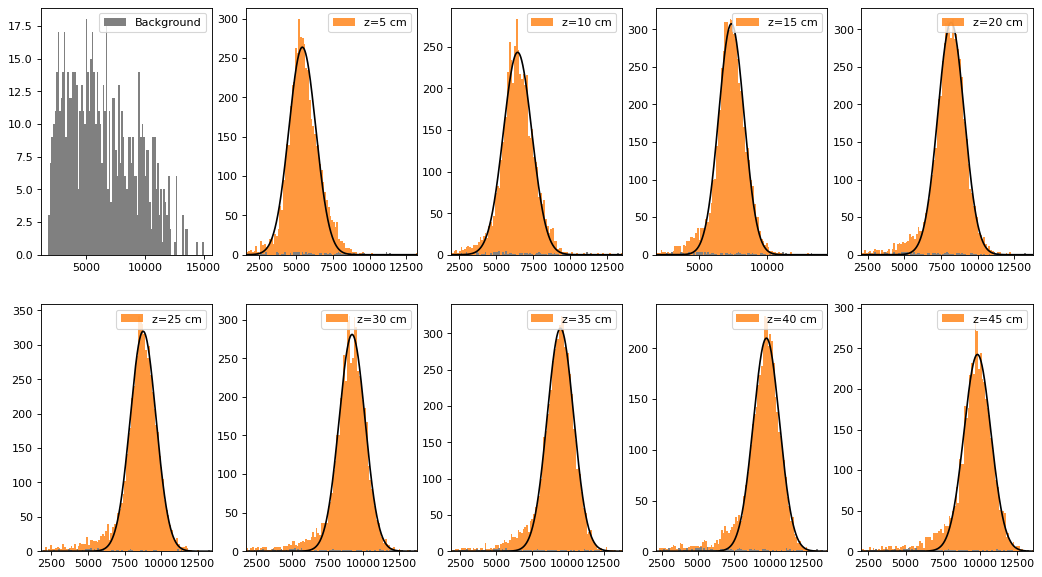

In [52]:
#@title Gaussian fit of the spectra, for clusters within 300px of the centre
fig, (ax) = plt.subplots(2,5, figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 

i = 1
j = 0
ax[0][0].hist(roi['Integral'].loc[roi['z[cm]']==0], bins=100, color='gray', label='Background')
ax[0][0].legend(loc=0)
Z_values = [5, 10, 15, 20, 25, 30, 35, 40, 45]
x0 = []
dx0 = []
sigma = []
dsigma = []
eres = []
deres = []
eres_sigma = []
deres_sigma = []
for z in Z_values:
  light = roi['Integral'].loc[(roi['z[cm]']==z) & (roi['R']<=300)]
  n, bins, patches = ax[j][i].hist(light, bins=100, label='z='+str(z)+' cm', color='tab:orange', lw=2, alpha=0.8)
  ax[j][i].hist(roi['Integral'].loc[(roi['z[cm]']==0) & (roi['R']<=300)], bins=100, color='gray')
  bin_middles = (bins[1:]+bins[:-1])/2
  x = np.linspace(0,15000, 15000)
  bpopt, bpcov = curve_fit(gauss, bin_middles, n, p0=[np.max(n), np.mean(light), 1000])
  bpcov = np.sqrt(np.diag(bpcov))
  ycalc = gauss(x, *bpopt)
  print('Z=', z, 'cm:')
  print('A=', ufloat(bpopt[0], 2*bpcov[0]))
  print('x0=', ufloat(bpopt[1], 2*bpcov[1]))
  x0.append(bpopt[1])
  dx0.append(2*bpcov[1])
  print('sigma=', ufloat(bpopt[2], 2*bpcov[2]))
  sigma.append(bpopt[2])
  dsigma.append(2*bpcov[2])
  energy_res=(2.355*ufloat(bpopt[2], 2*bpcov[2]))/ufloat(bpopt[1], 2*bpcov[1])*100
  print('eres=', energy_res)
  eres.append(energy_res.n)
  deres.append(energy_res.s)
  eres_sig=(ufloat(bpopt[2], 2*bpcov[2]))/ufloat(bpopt[1], 2*bpcov[1])*100
  eres_sigma.append(eres_sig.n)
  deres_sigma.append(eres_sig.s)
  display('-'*100)
  ax[j][i].legend(loc=1)
  ax[j][i].plot(x, ycalc, color='k', zorder=5)
  ax[j][i].set_xlim(np.min(bin_middles),np.max(bin_middles))

  i=i+1
  if i>4:
    j = 1
    i = i-5
  
plt.show()

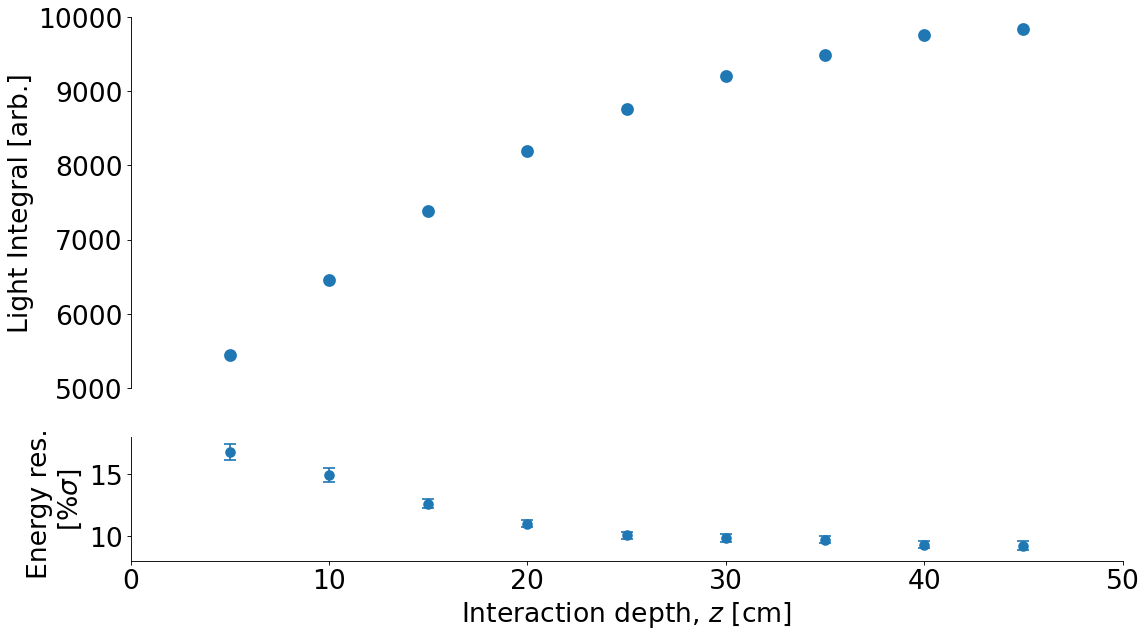

In [53]:
#@title Average light integral and energy resolution ($\sigma$) as a function of z
fig, (ax) = plt.subplots(2,1,figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k', gridspec_kw={'height_ratios': [3, 1]}) 
ax[0].errorbar(Z_values, x0, color='tab:blue', marker='o', markersize=10, lw=0,
            markeredgecolor='tab:blue', markeredgewidth=1.5, ecolor='tab:blue', elinewidth=1.5, capsize=5, capthick=1.5, label='$\sigma_T$')

ax[0].set_xlim(0,50)
ax[0].set_ylim(5000,10000)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].set_ylabel('Light Integral [arb.]', y=0.5, ha='center', fontsize=24)
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[0].spines["bottom"].set_visible(False)
ax[0].xaxis.set_visible(False)

ax[1].errorbar(Z_values, eres_sigma, yerr=deres_sigma, color='tab:blue', lw=0, marker='o', markersize=8, 
            markeredgecolor='tab:blue', markeredgewidth=1.5, ecolor='tab:blue', elinewidth=1.5, capsize=5, capthick=1.5)

ax[1].set_xlim(0,50)
ax[1].set_ylim(8,18)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].set_ylabel('Energy res. \n[%$\sigma$]', y=0.5, ha='center', fontsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[1].set_xlabel('Interaction depth, $z$ [cm]', x=0.5, ha='center', fontsize=24)

plt.show()

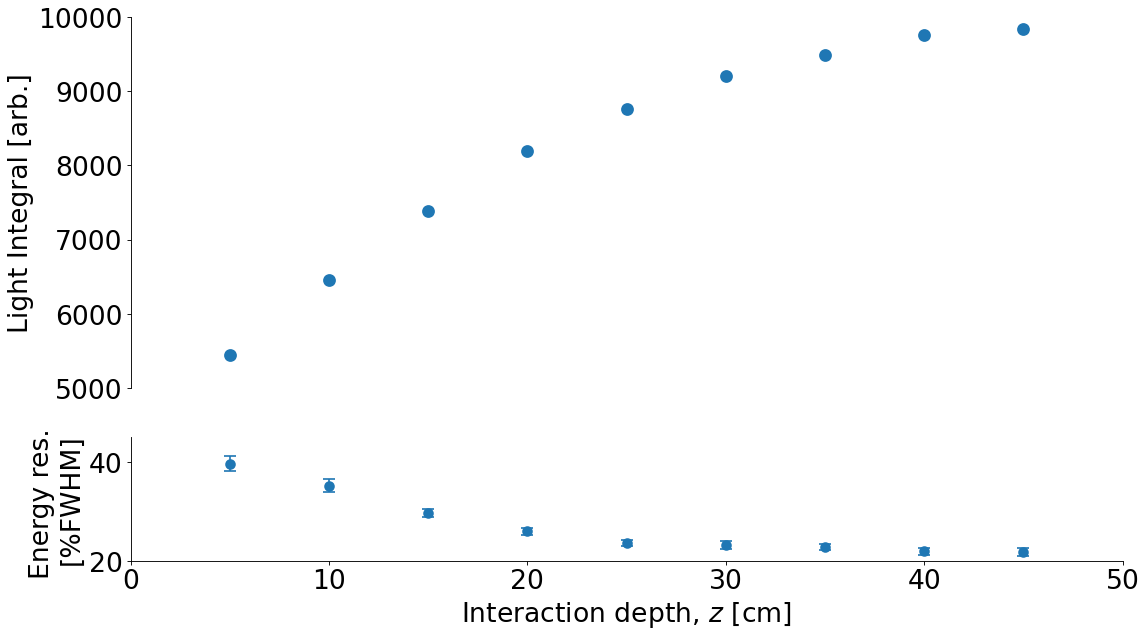

In [57]:
#@title Average light integral and energy resolution (FWHM) as a function of z
fig, (ax) = plt.subplots(2,1,figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k', gridspec_kw={'height_ratios': [3, 1]}) 
ax[0].errorbar(Z_values, x0, color='tab:blue', marker='o', markersize=10, lw=0,
            markeredgecolor='tab:blue', markeredgewidth=1.5, ecolor='tab:blue', elinewidth=1.5, capsize=5, capthick=1.5)

ax[0].set_xlim(0,50)
ax[0].set_ylim(5000,10000)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].set_ylabel('Light Integral [arb.]', y=0.5, ha='center', fontsize=24)
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[0].spines["bottom"].set_visible(False)
ax[0].xaxis.set_visible(False)

ax[1].errorbar(Z_values, eres, yerr=deres, color='tab:blue', lw=0, marker='o', markersize=8, 
            markeredgecolor='tab:blue', markeredgewidth=1.5, ecolor='tab:blue', elinewidth=1.5, capsize=5, capthick=1.5)

ax[1].set_xlim(0,50)
ax[1].set_ylim(20,45)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].set_ylabel('Energy res. \n[%FWHM]', y=0.5, ha='center', fontsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[1].set_xlabel('Interaction depth, $z$ [cm]', x=0.5, ha='center', fontsize=24)

plt.show()